In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
import torch
import gpytorch
from math import pi

import matplotlib.pyplot as plt
from util import *

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

# train_x = torch.tensor([[60,500],[60,1000],[60,1500],[60,2000],[60,2500],
#                         [100,500],[100,1000],[100,1500],[100,2000],[100,2500],
#                         [140,500],[140,1000],[140,1500],[140,2000],[140,2500],
#                         [180,500],[180,1000],[180,1500],[180,2000],[180,2500]], dtype=torch.double)

# train_y = torch.tensor([0,2,2,1,2,2,5,5,4,4,6,5,5,8,3,3,5,4,3,6], dtype=torch.double)


# x1_range = torch.linspace(0, 200, 1000)
# x2_range = torch.linspace(0, 3000, 3000)
# x1, x2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
# X_test = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)

#-------------------------------------------------------------------------------

# train_x = torch.rand(size=(20, 2),dtype=torch.double) * 6 - 3

# train_y = torch.tensor([0,2,2,1,2,2,5,5,4,4,6,5,5,8,3,3,5,4,3,6], dtype=torch.double)


# x1_range = torch.linspace(-4, 4, 101)
# x2_range = torch.linspace(-5, 5, 101)
# x1, x2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
# X_test = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)


In [9]:
train_x = torch.tensor([[0.6,5],[0.6,10],[0.6,15],[0.6,20],[0.6,25],
                        [1,5],[1,10],[1,15],[1,20],[1,25],
                        [1.4,5],[1.4,10],[1.4,15],[1.4,20],[1.4,25],
                        [1.8,5],[1.8,10],[1.8,15],[1.8,20],[1.8,25]], dtype=torch.double)

train_y = torch.tensor([0,2,2,1,2,2,5,5,4,4,6,5,5,8,3,3,5,4,3,6], dtype=torch.double)


x1_range = torch.linspace(0, 2, 1000)
x2_range = torch.linspace(0, 30, 3000)
x1, x2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
X_test = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)

In [10]:
train_x

tensor([[  60.,  500.],
        [  60., 1000.],
        [  60., 1500.],
        [  60., 2000.],
        [  60., 2500.],
        [ 100.,  500.],
        [ 100., 1000.],
        [ 100., 1500.],
        [ 100., 2000.],
        [ 100., 2500.],
        [ 140.,  500.],
        [ 140., 1000.],
        [ 140., 1500.],
        [ 140., 2000.],
        [ 140., 2500.],
        [ 180.,  500.],
        [ 180., 1000.],
        [ 180., 1500.],
        [ 180., 2000.],
        [ 180., 2500.]], dtype=torch.float64)

In [11]:
class ARDGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ARDGPModel(train_x, train_y, likelihood)

In [12]:
# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [13]:
model.train()
likelihood.train()

losses = []
x_lengthscales = []
y_lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    x_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    y_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 1].item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

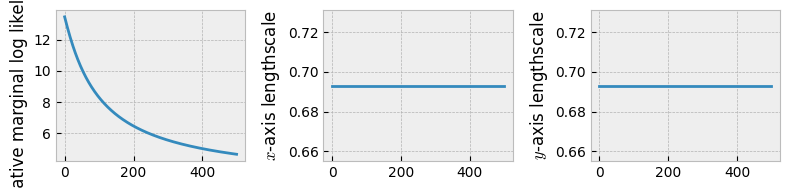

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(x_lengthscales)
ax[1].set_ylabel(r"$x$-axis lengthscale")

ax[2].plot(y_lengthscales)
ax[2].set_ylabel(r"$y$-axis lengthscale")

plt.tight_layout();